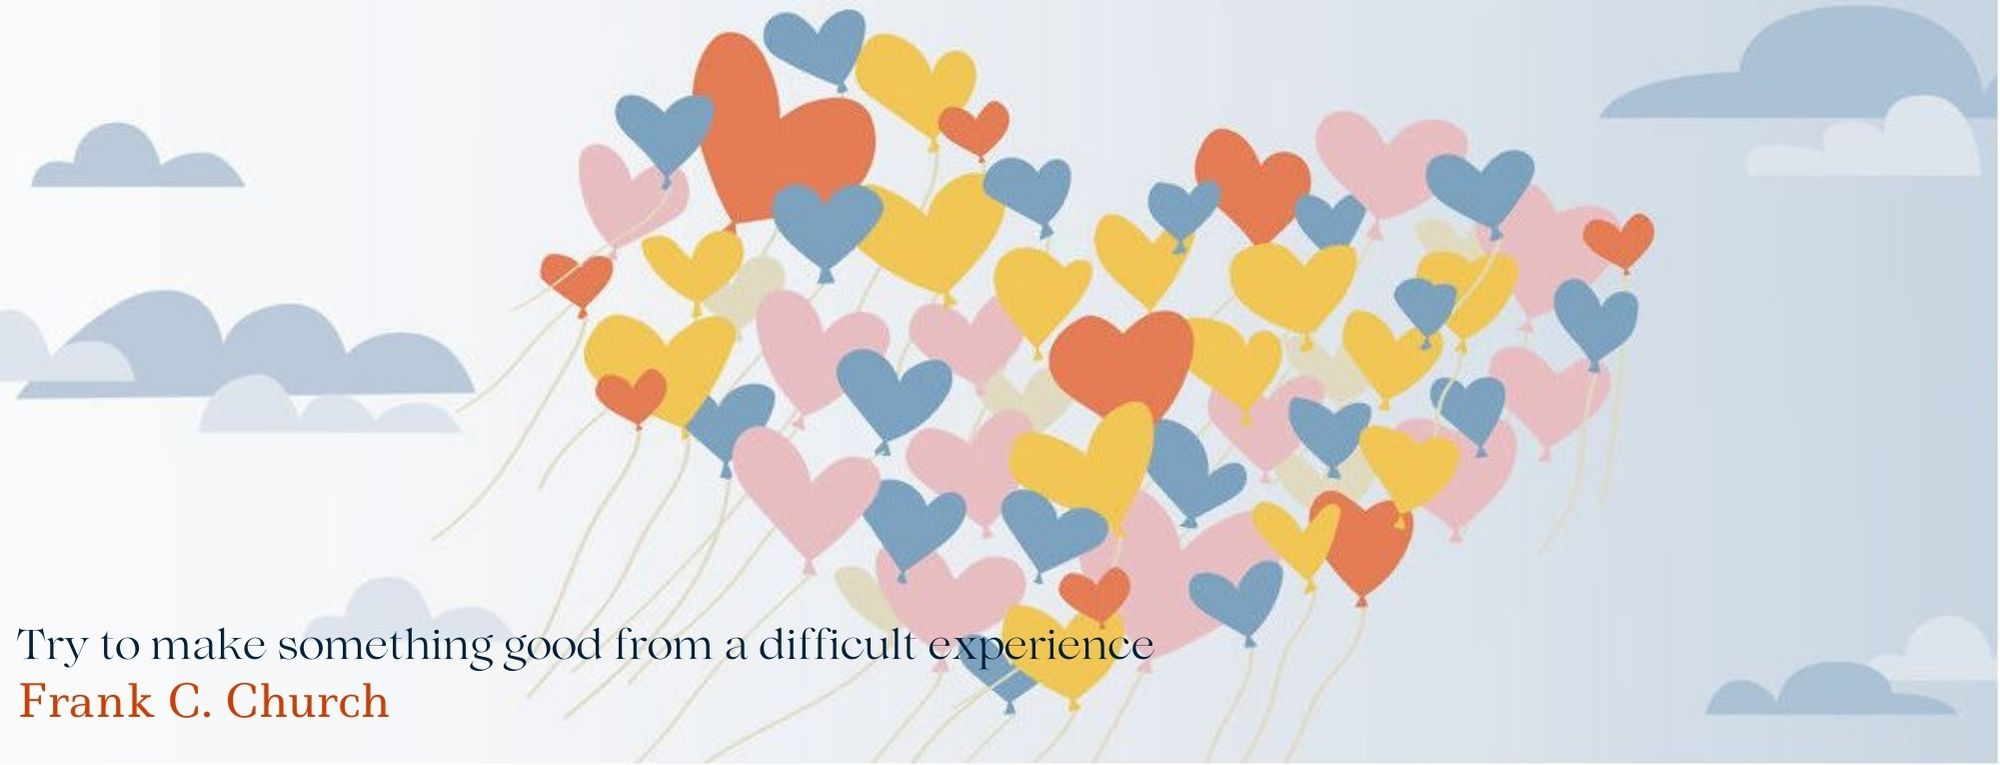

# DESCRIPTION

## Goal of the Competition  

The goal of this competition is to detect **`freezing of gait (FOG)`**, a debilitating symptom that afflicts many people with Parkinson’s disease.  

It is necessary to develop a machine learning model trained on data collected with a wearable 3D lower back sensor.  

This work will help researchers better understand when and why **`FOG episodes`** occur.  

This will improve the ability of healthcare professionals to optimally assess, manage and ultimately prevent **`FOG events`**. 


This event dataset contains 3D lower back accelerometer data from subjects who experienced freeze-walking episodes, a disability symptom common among people with Parkinson's disease. Freeze gait (FOG) is perceived negatively by the likelihood of walking and experiencing movement and independence.  

Our goal is to start and stop an episode of each fade, as well as the appearance in a series of three types of fade events of the march: "StartHesitation", "Turn" and "Walking". 

> Description of values:


|   Name:   |   Type:   |     Meaning:    |
|-----------|-----------|-----------------|
|  **Id**   |   object  | The data series the event occured in |
|**Time**   |   int64   | An integer timestep. Series from the tdcsfog dataset are recorded at 128Hz (128 timesteps per second), while series from the defog and daily series are recorded at 100Hz (100 timesteps per second). |
| **AccV**  |  float64  | Acceleration from a lower-back sensor on three axes: V - vertical. | 
| **AccML** |  float64  | Acceleration from a lower-back sensor on three axes: ML - mediolateral|
| **AccAP** |  float64  |  Acceleration from a lower-back sensor on three axes: AP - anteroposterior|                           
| **Event** |  float64  | Indicator variable for the occurrence of any FOG-type event. Present only in the notype series, which lack type-level annotations|
| **Valid** |  object   | There were cases during the video annotation that were hard for the annotator to decide if there was an Akinetic (i.e., essentially no movement) FoG or the subject stopped voluntarily. Only event annotations where the series is marked true should be considered as unambiguous |
| **Task** |   object   | Series were only annotated where this value is true. Portions marked false should be considered unannotated |
|**StartHesitation**| int64 | Indicator variable for the occurrence of each of the event types|
| **Turn** |int64 | Indicator variable for the occurrence of each of the event types|
| **Walking**|int64 | Indicator variable for the occurrence of each of the event types|

 
 NB! **Data is in units of m/s^2 for tdcsfog/ and g for defog/ and notype** 

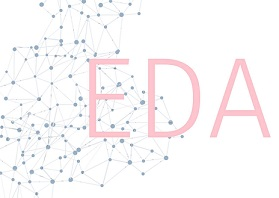

# Exploratory Data Analysis

## Imports  

*******************************

In [1]:
import pandas as pd
import numpy as np

import os
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle

## Settings  

**************************

In [2]:
# Pandas defaults
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
pd.options.display.max_columns = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.colheader_justify = 'left'

In [3]:
# others
warnings.filterwarnings('ignore')

## Constants  

*****************************************

In [4]:
#PATH_REMOTE = ''                    # remote path to data

CR = '\n'                                     # new line
RANDOM_STATE = RANDOM_SEED = RS = 66          # random_state
TEST_FRAC = 0.1                               # delayed sampling fraction

N_TRIALS = 10                                 # number of tries for fitting of hyperparameters
N_CV = 4                                      # number of folds during cross-validation
MAX_ITER = 1000                               # max number of iterations for LinearRegression
DEGREE_POLYNOMIAL = 5                         # degree for polynomial expansion

# Data preparation  

***************************************************************************

## Read and Check data


In [5]:
# Daily, Defog, and Tdcsfog data:

daily_df = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/daily_metadata.csv')
defog_df = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv')
tdcsfog_df = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv')

# Other three dataframes:

events_df = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/events.csv')
subjects_df = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/subjects.csv')
tasks_df = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tasks.csv')

In [6]:
daily_df.head()

,Id,Subject,Visit,Beginning of recording [00:00-23:59]
0,00c4c9313d,3d8b73,1,10:19
1,07a96f89ec,a15b56,1,07:30
2,0d1bc672a8,21e523,2,08:30
3,0e333c9833,b068a2,1,11:30
4,164adaed7b,ffa798,1,13:00


In [7]:
defog_df.head()

,Id,Subject,Visit,Medication
0,02ab235146,ab54e1,2,on
1,02ea782681,bf608b,2,on
2,06414383cf,c0b71e,2,off
3,092b4c1819,b6a627,1,off
4,0a900ed8a2,b7bd52,2,on


In [8]:
tdcsfog_df.head()

,Id,Subject,Visit,Test,Medication
0,003f117e14,13abfd,3,2,on
1,009ee11563,d81e3a,4,2,on
2,011322847a,203e85,2,2,on
3,01d0fe7266,203e85,2,1,off
4,024418ba39,cecfb8,19,3,on


In [9]:
events_df.head()

,Id,Init,Completion,Type,Kinetic
0,003f117e14,8.61,14.77,Turn,1.00
1,009ee11563,11.38,41.18,Turn,1.00
2,009ee11563,54.66,58.78,Turn,1.00
3,011322847a,28.10,30.30,Turn,1.00
4,01d0fe7266,30.32,31.88,Turn,1.00


In [10]:
subjects_df.head()

,Subject,Visit,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,NFOGQ
0,04fcdb,1.00,63,M,3.00,30.00,NaN,0
1,05595e,1.00,56,M,8.00,28.00,NaN,0
2,0967b2,1.00,59,M,10.00,38.00,48.00,19
3,0967b2,2.00,59,M,10.00,37.00,44.00,13
4,097078,NaN,70,F,10.00,27.00,50.00,20


In [11]:
tasks_df.head()

,Id,Begin,End,Task
0,02ab235146,10.00,190.48,Rest1
1,02ab235146,211.24,271.56,Rest2
2,02ab235146,505.88,522.40,4MW
3,02ab235146,577.96,594.64,4MW-C
4,02ab235146,701.32,715.28,MB1


### Checking the content of dataframes

In [12]:
dfs = [daily_df, defog_df, tdcsfog_df, events_df, subjects_df, tasks_df]

output = "\n".join([f"{df.__class__.__name__}: {len(df)}" for df in dfs])
print(output)

DataFrame: 65
DataFrame: 137
DataFrame: 833
DataFrame: 3712
DataFrame: 173
DataFrame: 2817


In [13]:
def show_info(daily_df, defog_df, tdcsfog_df, events_df, subjects_df, tasks_df):
    data_frames = [("daily_df", daily_df), 
                   ("defog_df", defog_df),
                   ("tdcsfog_df", tdcsfog_df),
                   ("events_df", events_df),
                   ("subjects_df", subjects_df),
                   ("tasks_df", tasks_df)]
    for name, df in data_frames:
        print(f"\033[1m{'*'*10} {name} {'*'*10}\033[0m")
        df.info()
        print(f"{'*'*26}\n")

In [14]:
show_info(daily_df, defog_df, tdcsfog_df, events_df, subjects_df, tasks_df)

********** daily_df **********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 4 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Id                                    65 non-null     object
 1   Subject                               65 non-null     object
 2   Visit                                 65 non-null     int64 
 3   Beginning of recording [00:00-23:59]  65 non-null     object
dtypes: int64(1), object(3)
memory usage: 2.2+ KB
**************************

********** defog_df **********
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137 entries, 0 to 136
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          137 non-null    object
 1   Subject     137 non-null    object
 2   Visit       137 non-null    int64 
 3   Medication  137 non-null    object
dtypes: int64(1), 

In [15]:
def remove_spaces(df):
    """
    The function removes extra spaces in the names of the dataframe columns
    
    :param df: pandas.DataFrame, dataframe to process
    :return: pandas.DataFrame,dataframe with column names without extra spaces
    """
    df.columns = df.columns.str.strip()
    return df

In [16]:
daily_df = remove_spaces(daily_df)
defog_df = remove_spaces(defog_df)
tdcsfog_df = remove_spaces(tdcsfog_df)
events_df = remove_spaces(events_df)
subjects_df = remove_spaces(subjects_df)
tasks_df = remove_spaces(tasks_df)

### Now I will sequentially merge the dataframes into a new dataset. I'll remove the extra columns. And on the new dataset I will conduct a feature study and train the model

In [17]:
defog_df = defog_df.drop('Medication', axis=1) #Remove the column with lower values

df = pd.concat([daily_df, defog_df, tdcsfog_df, events_df, subjects_df, tasks_df], axis=1, join='inner')

In [18]:
df = df.loc[:,~df.columns.duplicated() | df.columns.isin(['Medication'])]

In [19]:
#  deleting columns'Completion' and 'NFOGQ'

df = df.drop(['Completion', 'NFOGQ', 'Subject'], axis=1)

# column binarization 'Init', 'Sex' , 'Medication'

df['Init'] = df['Init'].apply(lambda x: 1 if x > 0 else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'M' else 0)
df['Medication'] = df['Medication'].apply(lambda x: 1 if x == 'on' else 0)

**'Init' implies FOG commit I will make it a binary value and then I will compare with other features as a feature of fixed FOG**

In [20]:
display(df)
df.info()

,Id,Visit,Beginning of recording [00:00-23:59],Test,Medication,Init,Type,Kinetic,Age,Sex,YearsSinceDx,UPDRSIII_On,UPDRSIII_Off,Begin,End,Task
0,00c4c9313d,1,10:19,2,1,1,Turn,1.00,63,1,3.00,30.00,NaN,10.00,190.48,Rest1
1,07a96f89ec,1,07:30,2,1,1,Turn,1.00,56,1,8.00,28.00,NaN,211.24,271.56,Rest2
2,0d1bc672a8,2,08:30,2,1,1,Turn,1.00,59,1,10.00,38.00,48.00,505.88,522.40,4MW
3,0e333c9833,1,11:30,1,0,1,Turn,1.00,59,1,10.00,37.00,44.00,577.96,594.64,4MW-C
4,164adaed7b,1,13:00,3,1,1,Turn,1.00,70,0,10.00,27.00,50.00,701.32,715.28,MB1
5,17e0c0dc86,1,08:00,2,1,1,Turn,1.00,67,1,6.00,16.00,61.00,738.32,743.16,MB2a
6,1c3719ea59,1,08:00,2,1,1,Turn,1.00,75,0,3.00,22.00,24.00,747.08,752.16,MB2b
7,1cf80df2d6,1,09:00,3,1,1,Turn,1.00,75,0,3.00,21.00,30.00,775.64,787.56,MB3-R
8,24016102f2,1,08:00,1,1,1,Turn,1.00,61,0,1.00,14.00,NaN,803.68,813.56,MB3-R
9,276630050d,1,12:00,3,1,1,Turn,1.00,67,0,4.00,NaN,18.00,829.44,831.30,MB3-L


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 16 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Id                                    65 non-null     object 
 1   Visit                                 65 non-null     int64  
 2   Beginning of recording [00:00-23:59]  65 non-null     object 
 3   Test                                  65 non-null     int64  
 4   Medication                            65 non-null     int64  
 5   Init                                  65 non-null     int64  
 6   Type                                  65 non-null     object 
 7   Kinetic                               65 non-null     float64
 8   Age                                   65 non-null     int64  
 9   Sex                                   65 non-null     int64  
 10  YearsSinceDx                          65 non-null     float64
 11  UPDRSIII_On          

#### Let's look at the values of our data again:

>**Id:** The data series in which the FOG event occurred  
>**Visit:** Laboratory visits consist of baseline evaluation, two post-treatment evaluations for different stages of treatment, and one follow-up evaluation    
>**Beginning of recording [00:00-23:59]** test recording start   
>**Test:**  Indicates which three types of tests were performed, from simple (1) to complex (3)   
>**Medication** - Subjects may have been taking medication for parkinsonism during recording  
>**Init** - FOG precedent 
>**Type** - FOG type: "StartHesitation", "Turn" and "Walk"   
>**Kinetic** - Whether the event was kinetic ( 1) and involved movement, or akinetic ( 0) and static 
>**Age** - Patient's age  
>**Sex** - Patient gender  
>**YearsSinceDx** - How many years since the diagnosis of Parkinson's  
>**UPDRSIII_On** - Assessment according to the Unified Parkinson's Disease Assessment Scale when taking/withdrawing treatment, respectively  
>**UPDRSIII_Off** - Assessment according to the Unified Parkinson's Disease Assessment Scale when taking/withdrawing treatment, respectively 
>**Begin** - Time (since) the start of the task execution  
>**End** - 
Time (since) task completion  
>**Task** - One of the seven task types in the DeFOG protocol described on this page https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction/overview/additional-data-documentation  

**Exploring the possibilities for combining features and objects, I decided to stop at the option with fewer features but with a full set of objects**

I also decided to abandon the personalization of the study and focus on the relationship of physical signs and manifestations and remove the initialization data

### Data visualization

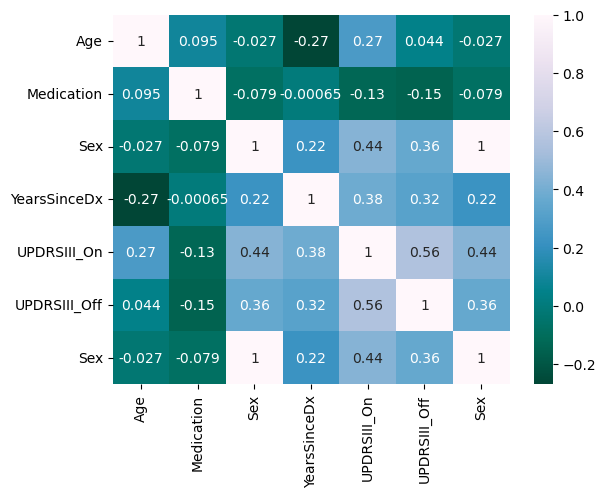

In [21]:
# Creating a correlation matrix

corr_matrix = df[['Age', 'Medication', 'Sex', 'YearsSinceDx', 'UPDRSIII_On', 'UPDRSIII_Off', 'Sex']].corr()


sns.heatmap(corr_matrix, cmap="PuBuGn_r", annot=True)


plt.show()

The correlation between the features is moderate, this should be noted when training the model in order to avoid overfitting. It is also interesting to see the ratio of parameters **UPDRSIII_On** and **Sex**

I take the Init indicator as a basis for comparisons - since it is an indicator of the FOG event start time, and in accordance with its value it was defined as True (1) and False (2) in fact, the sample we received is a positive FOG and 65 cases have a full data set

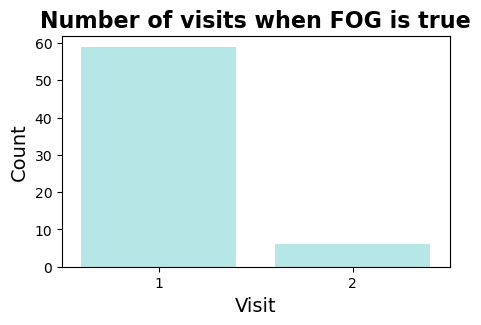

In [22]:
# Creating a data subset where 'Init' is 1

subset = df[df['Init'] == 1]

# Counting the number of visits with value_counts()

visit_counts = subset['Visit'].value_counts()

# Building a bar chart

fig, ax = plt.subplots(figsize=(5,3))
sns.barplot(x=visit_counts.index, y=visit_counts.values, color='PaleTurquoise', ax=ax)
ax.set_xlabel('Visit', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Number of visits when FOG is true', fontsize=16, fontweight='bold')
plt.show()


> Laboratory visits consist of baseline evaluation, two post-treatment evaluations for different stages of treatment, and one follow-up evaluation. That is, most of the patients received a score of 1

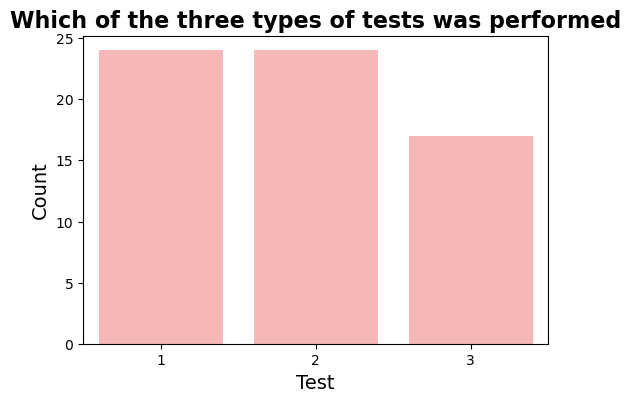

In [23]:
# Counting the number of visits with value_counts()

visit_counts = subset['Test'].value_counts()

# Building a bar chart


fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=visit_counts.index, y=visit_counts.values, color="#FFADAE", ax=ax)
ax.set_xlabel('Test', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Which of the three types of tests was performed', fontsize=16, fontweight='bold')
plt.show()

> Approximately 25 patients were able to complete both trials 1 and 2.  
> Approximately 16 patients completed the most challenging 3 trials

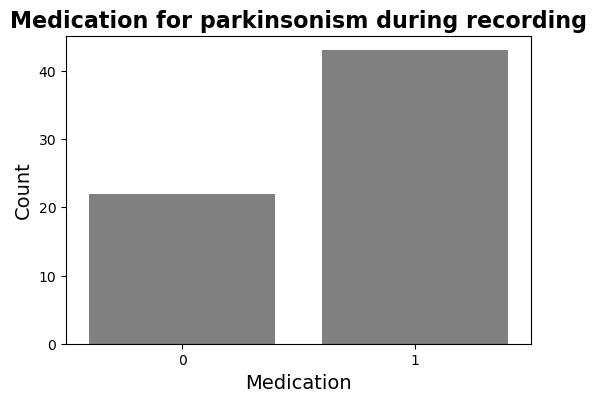

In [24]:
# Counting the number of visits with value_counts()

visit_counts = subset['Medication'].value_counts()

# Building a bar chart

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=visit_counts.index, y=visit_counts.values, color="#808080", ax=ax)
ax.set_xlabel('Medication', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Medication for parkinsonism during recording', fontsize=16, fontweight='bold')
plt.show()

> Most of the patients were taking drugs for parkinsonism at the time of the study

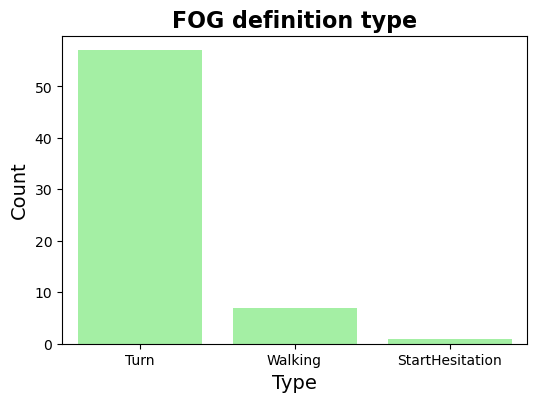

In [25]:
# Counting the number of visits with value_counts()

visit_counts = subset['Type'].value_counts()

# Building a bar chart

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=visit_counts.index, y=visit_counts.values, color="palegreen", ax=ax)
ax.set_xlabel('Type', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('FOG definition type', fontsize=16, fontweight='bold')
plt.show()

> Which type of FOG occurred more frequently: "Turn"

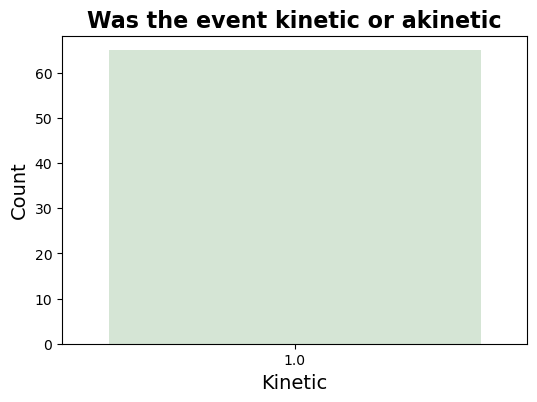

In [26]:
# Counting the number of visits with value_counts()

visit_counts = subset['Kinetic'].value_counts()

#Building a bar chart

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=visit_counts.index, y=visit_counts.values, color="#D2E8D2", ax=ax)
ax.set_xlabel('Kinetic', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Was the event kinetic or akinetic', fontsize=16, fontweight='bold')
plt.show()

> In my sample, all FOG cases included movement

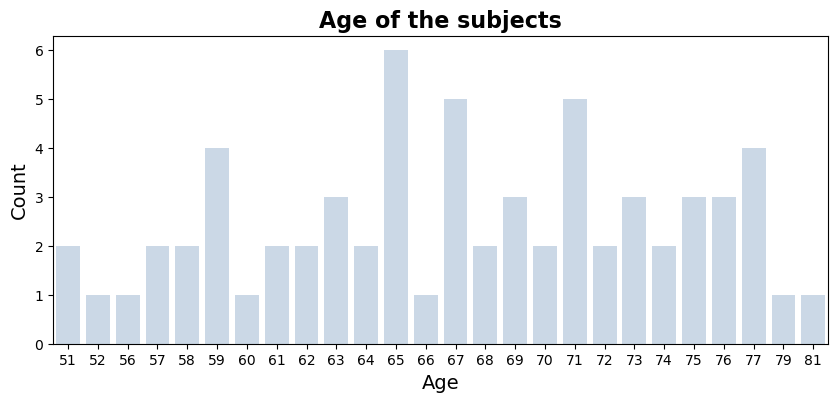

In [27]:
# Counting the number of visits with value_counts()

visit_counts = subset['Age'].value_counts()

# Building a bar chart

fig, ax = plt.subplots(figsize=(10,4))
sns.barplot(x=visit_counts.index, y=visit_counts.values, color="#C7D8EA", ax=ax)
ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Age of the subjects', fontsize=16, fontweight='bold')
plt.show()

> As we can see, the age of patients does not have a stable increase or decrease, there are groups that stand out, but for example, the dynamics of an increase in an older group is insignificant

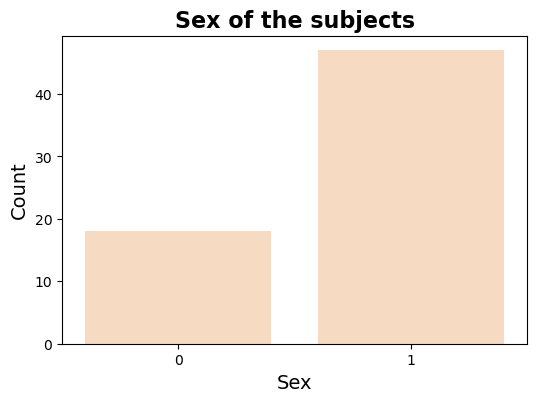

In [28]:
# Counting the number of visits with value_counts()

visit_counts = subset['Sex'].value_counts()

# Building a bar chart

fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(x=visit_counts.index, y=visit_counts.values, color="#FFDAB9", ax=ax)
ax.set_xlabel('Sex', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Sex of the subjects', fontsize=16, fontweight='bold')
plt.show()

> Men are more frequent patients with the disease

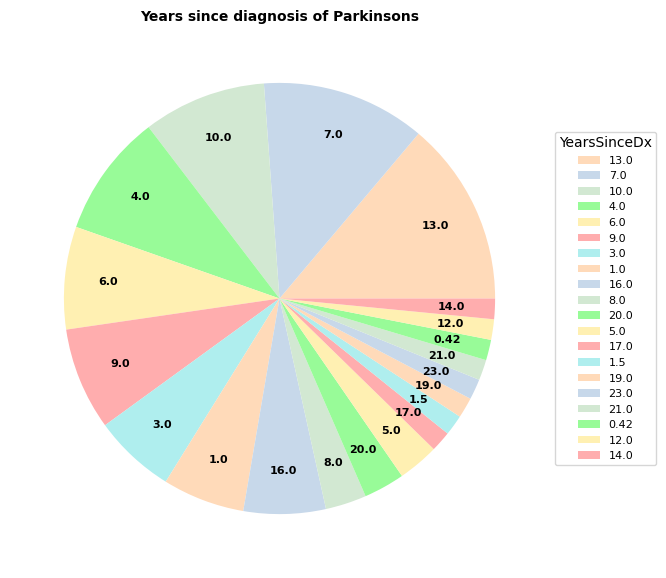

In [29]:
# Counting the number of visits with value_counts()

visit_counts = subset['YearsSinceDx'].value_counts()

# Colors for sectors

colors = ["#FFDAB9", "#C7D8EA", "#D2E8D2", "palegreen", '#FFF0B2','#FFADAE','PaleTurquoise']

# Building a pie chart

fig, ax = plt.subplots(figsize=(10,7))
wedges, _ = ax.pie(visit_counts.values, colors=colors)
ax.legend(wedges, visit_counts.index, title='YearsSinceDx', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
ax.set_title('Years since diagnosis of Parkinsons', fontsize=10, fontweight='bold')

# Adding text labels

for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = wedge.r * 0.80 * np.cos(np.radians(angle))
    y = wedge.r * 0.80 * np.sin(np.radians(angle))
    ax.text(x, y, visit_counts.index[i], ha='center', va='center', fontsize=8, fontweight='bold')
    
plt.show()

> 7 years, 10 years and 13 years are the most common times from diagnosis to examination

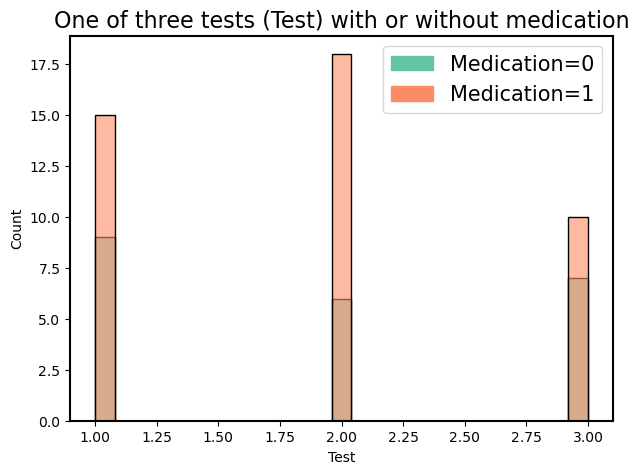

In [30]:
fig, ax = plt.subplots(figsize=(7,5))

colors = sns.color_palette('Set2', n_colors=len(df['Medication'].unique()))

for i, (medication, data) in enumerate(df.groupby('Medication')):
    sns.histplot(data=data, x='Test', bins=25, color=colors[i],multiple='stack',alpha=0.6, ax=ax)

labels = ['Medication=0', 'Medication=1']

patches = [mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(labels))]

ax.legend(handles=patches,fontsize=15)

ax.set_title('One of three tests (Test) with or without medication', fontsize=16)
ax.set_xlabel('Test', fontsize=10)
ax.set_ylabel('Count', fontsize=10)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)

plt.show()

> It was easy to assume that patients who took the drug were more successful on the Test

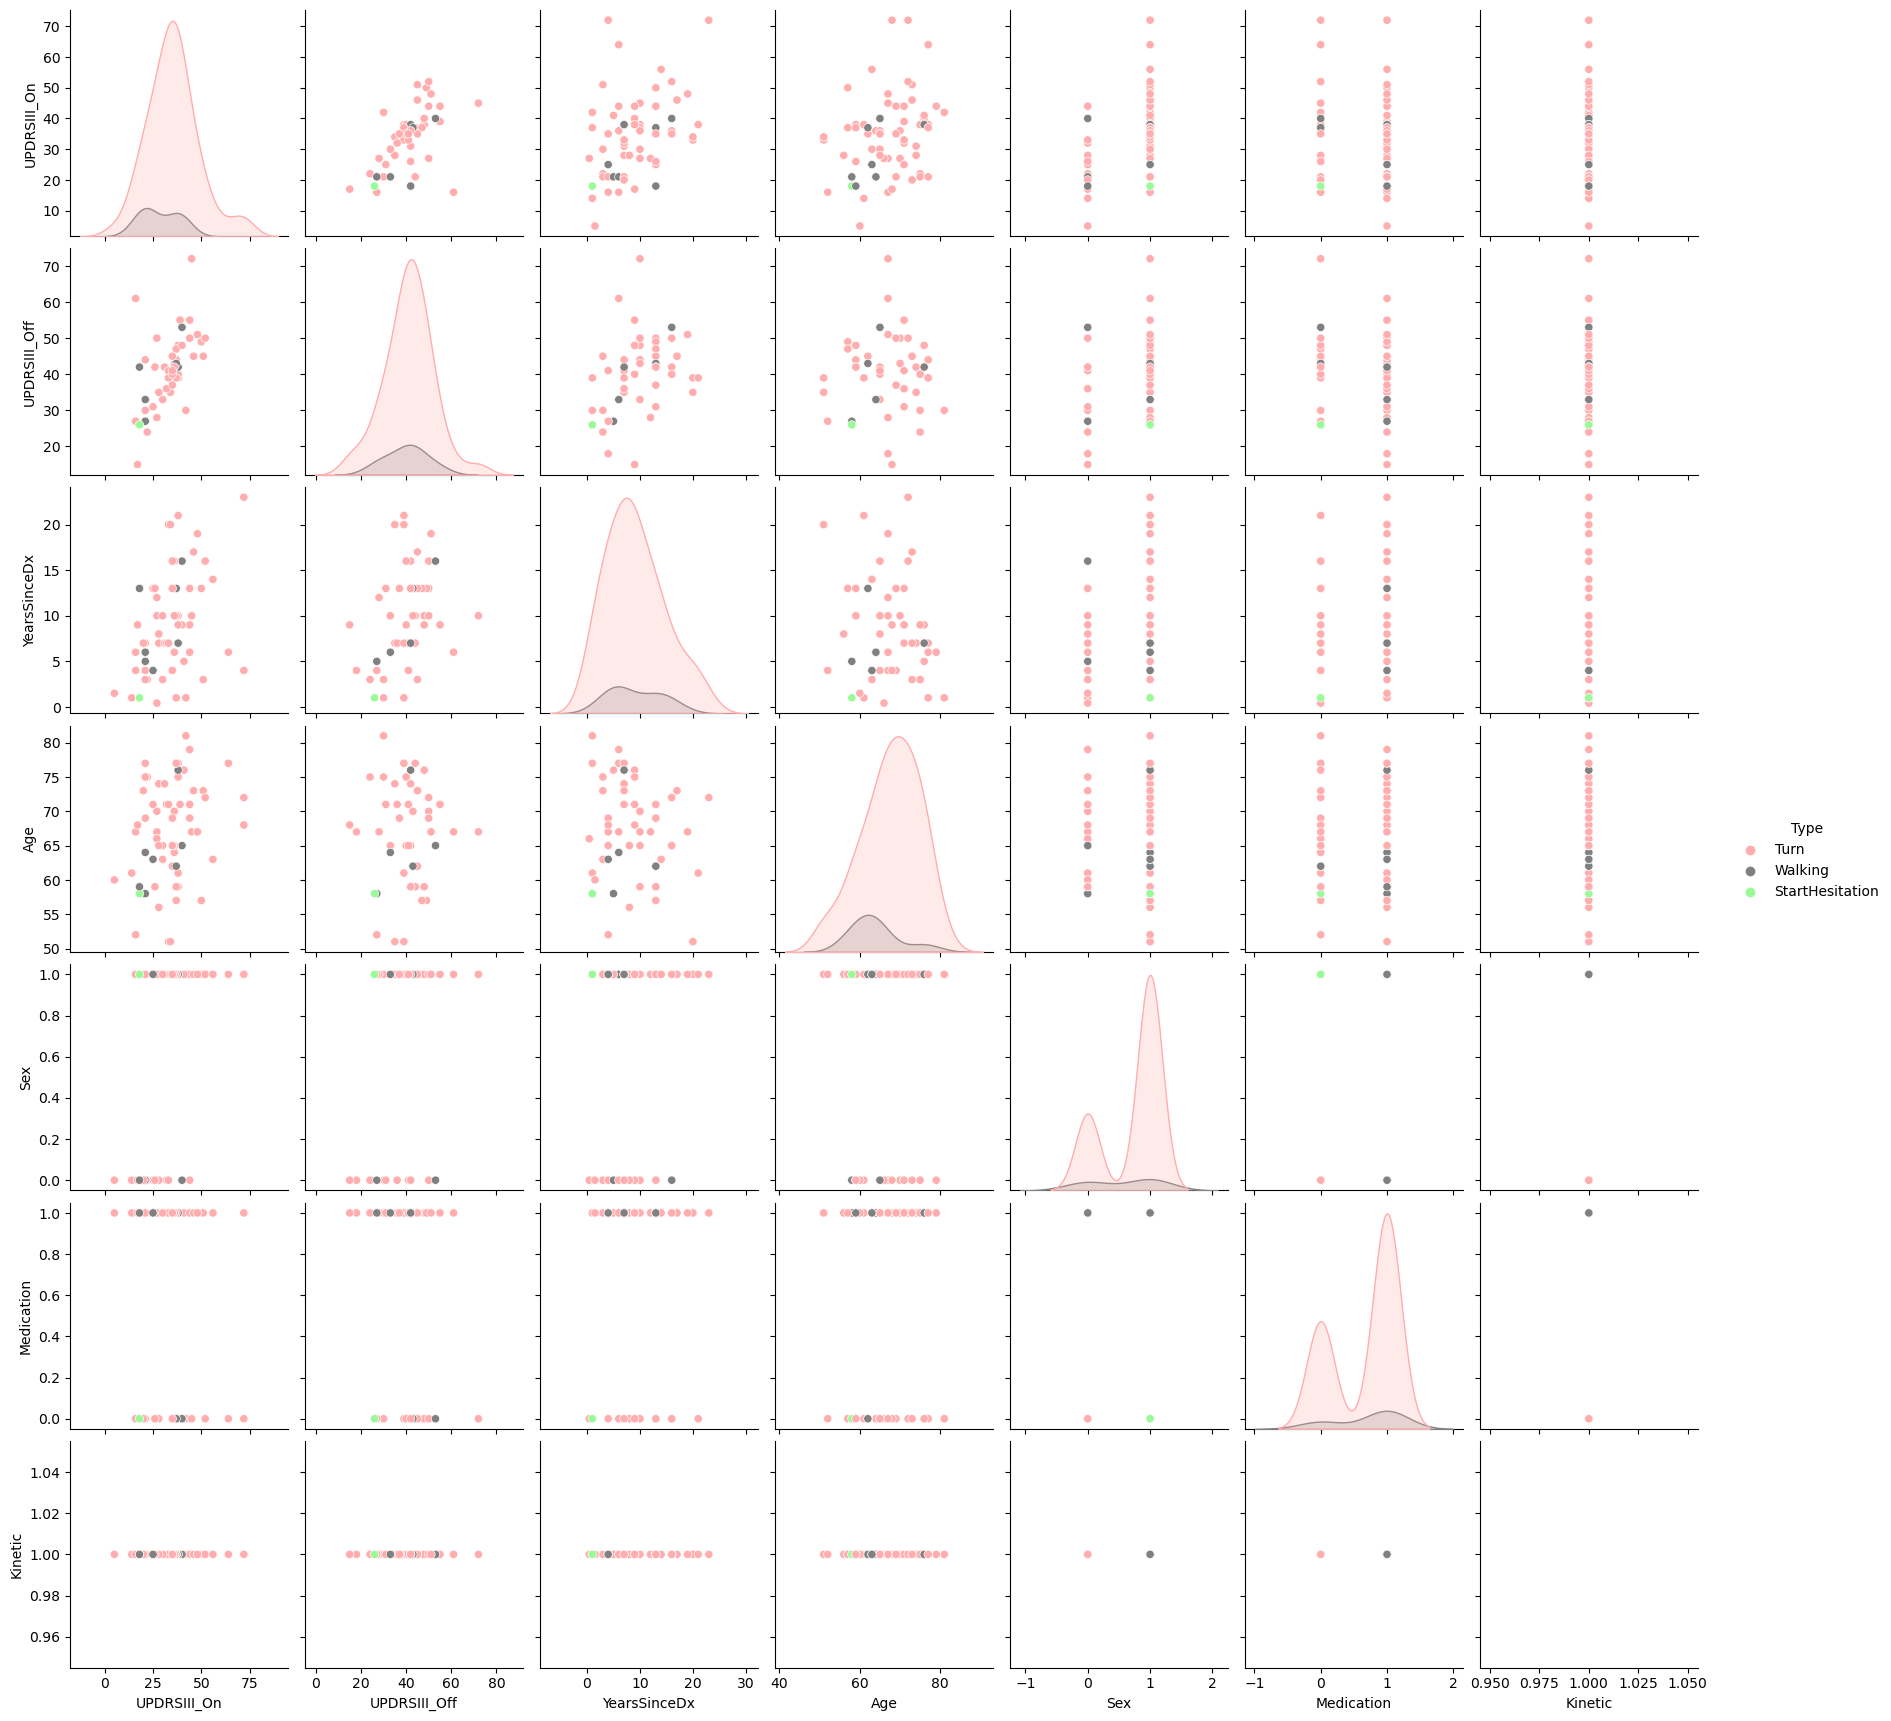

In [31]:
colors = ["#FFADAE", "#808080", "palegreen"]
sns.set_palette(colors)

sns.pairplot(data=df, vars=['UPDRSIII_On', 'UPDRSIII_Off', 'YearsSinceDx', 'Age','Sex', 'Medication', 'Kinetic'], hue='Type')

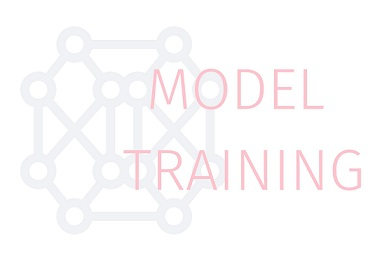

In [32]:
# Separation of features into numerical and categorical

numerical_features = ['Test','Medication','Init', 'Kinetic', 'Age', 'Sex', 'YearsSinceDx', 'UPDRSIII_On', 'UPDRSIII_Off']
categorical_features = ['Type']

In [33]:
# Coding of categorical features

encoder = OneHotEncoder()
categorical_data = encoder.fit_transform(df[categorical_features])

In [34]:
# Combining coded categorical features with numeric features

X = pd.concat([df[numerical_features], pd.DataFrame(categorical_data.toarray(), columns=encoder.get_feature_names())], axis=1)

# Target variable

y = df['Age']

In [35]:
# Separation into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.fillna(X_train.median())
X_test = X_test.fillna(X_train.median())

### Model 1. Gradient Boosting

In [36]:
# Create Model and Hyperparameters

gb = GradientBoostingClassifier()
params = {
    'n_estimators': [50, 200, 500],
    'max_depth': [3, 5, 10],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Finding the Best Hyperparameters

grid_search = GridSearchCV(gb, params, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Evaluation of the quality of the model on the test sample

y_pred = grid_search.predict(X_test)
test_score = accuracy_score(y_test, y_pred)

# Deriving of results

print('Best params:', grid_search.best_params_)
print('Accuracy (CV):', grid_search.best_score_)
print('Accuracy (test):', test_score)

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Accuracy (CV): 0.5181818181818182
Accuracy (test): 0.3076923076923077


### Model 2. Random Forest

In [37]:
# Defining Hyperparameters

param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [2, 3, 5, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Create a Model

rf = RandomForestClassifier()

# Selecting hyperparameters using GridSearchCV

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 0.6381818181818181


In [38]:
# Saving the model using pickle

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

In [39]:
# Loading the model from the pickle file

with open('rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

In [40]:
y_pred = rf_model.predict(X_test)
test_ids = X_test.index

In [41]:
# y_pred_flat_padded = np.pad(y_pred, (0, 3 - len(y_pred) % 3), mode='constant')
# submission = pd.DataFrame({'Id': test_ids})
# submission['Id'] = submission['Id'].iloc[:5]
# submission[['StartHesitation', 'Turn', 'Walking']] = pd.DataFrame(y_pred_flat_padded.reshape((-1, 3)), columns=['StartHesitation', 'Turn', 'Walking'])

In [42]:
submission = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/sample_submission.csv')


In [43]:
print(submission)

       Id                  StartHesitation  Turn  Walking
0            003f117e14_0  0                0     0      
1            003f117e14_1  0                0     0      
2            003f117e14_2  0                0     0      
3            003f117e14_3  0                0     0      
4            003f117e14_4  0                0     0      
...                   ...              ...   ...      ...
286365  02ab235146_281683  0                0     0      
286366  02ab235146_281684  0                0     0      
286367  02ab235146_281685  0                0     0      
286368  02ab235146_281686  0                0     0      
286369  02ab235146_281687  0                0     0      

[286370 rows x 4 columns]


In [44]:
submission.to_csv('submission.csv',index=False)

The result of the model evaluation on the metric was 0.63, which means that the model explains approximately 63% of the variance of the target variable (Age column). But it must be taken into account that we trained the model on an extremely truncated data sample, so overfitting is possible.

The purpose of my experiment was to see in a small piece of data the relationship between the occurrence of FOG and physical indicators, for example:

>**Age** - we saw that FOG episodes occur at different ages and do not have a pronounced growth pattern, but it is also noticeable that before 65 years of age, the types "StartHesitation" (rarely) and "Walk" (more often) occur and starting from 65 the "Turn" type predominates both with and without therapy
>**Sex** - Men in the resulting dataset become patients more often, and the density of the number of patients older than 65 increases. But for both genders, more often these are patients over the age of 65

>**Medication** - Non-medicated patients included those whose FOG type was "StartHesitation" and "Walking". And those who took more often belong to the FOG "Turn" type, it is important to note that this type is the most common in both cases. Also, it is interesting that patients with the "StartHesitation" type were men not taking medication, and with the "Walking" type, women were not taking medication

>**YearsSinceDx** - more often than 10 years passed from the moment of diagnosis to the study in women, the range of male patients is much higher (but we remember that there are more male patients) 
 
>**Kinetic** - In women with the "Turn" type, men are more typical with the "Walking" type. Those who take the drug more often have the "Turn" type, while those who do not take the "Walking" type


I also made two algorithms that can be used on this set, here I deviated a little from the task since this is an experimental project and made the patient's age the goal, so the models predict in which age groups FOG is more possible   

**Gradient Boosting** - showed a very low score of 0.49 and 0.30 on the test
**Random Forest** - showed a higher result 0.63